# UN Analysis

Analysis of UN actors in agreement-actor networks.


In [1]:
__author__      = 'Roy Gardner'

%run ./network_functions.py


## Load the agreement-actor data

- Load data into a binary-valued relation matrix (BVRM) with agreements in rows and actors in columns
- Matrix values are zero except where a relation between an agreement and an actor exists where the value is one
- Apart from the matrix other data are extracted or computed
- All data are stored in data_dict


In [3]:

data_path = './data/'
nodes_file = 'node_table.csv'
links_file = 'links_table.csv'
agreements_dict = 'agreements_dict.json'

data_dict = load_agreement_actor_data(nodes_file,links_file,agreements_dict,data_path)
print(data_dict.keys())


dict_keys(['agreements_dict', 'dates_dict', 'nodes_data', 'nodes_header', 'links_data', 'links_header', 'agreement_vertices', 'actor_vertices', 'vertices_dict', 'color_map', 'matrix'])


In [4]:
print(len(data_dict['agreement_vertices']))
print(len(data_dict['actor_vertices']))



1642
1092


## Collect UN actor indices and IDs

In [5]:

un_actors_list = []

for actor_index,actor_id in enumerate(data_dict['actor_vertices']):
    if len(actor_id) == 0:
        continue
    if not actor_id.startswith('IGO_') and not actor_id.startswith('COA_'):
        continue
    actor_data = data_dict['vertices_dict'][actor_id]
    actor_name = actor_data[data_dict['nodes_header'].index('node_name')]
    if 'United Nations' in actor_name or actor_name.startswith('UN') or ' UN' in actor_name:
        un_actors_list.append((actor_index,actor_id,actor_name))

un_actors_list = sorted(un_actors_list,key=lambda t:t[2])

# Print ready for insertion in LaTex document
latex = False
if latex:
    for t in un_actors_list:
        s = t[2] + ' & ' + '\\_'.join(t[1].split('_')) + ' \\\\'
        print(s)
        print('\\hline')
    

## Get UN actor biadjacency matrices

There are two matrices:

1. UN-only matrix: 
    - Rows are agreements that have at least one UN signatory
    - Columns are UN actors
2. UN actors and non-UN co-signatories matrix:
    - Rows are agreements that have at least one UN signatory (as above)
    - Columns are all the actors who are signatories to the row agreements

The indices of the agreements and actors that constitute the above matrices are:

- agreement_indices: Indices into `data_dict['agreement_vertices']` and therefore rows of `data_dict['matrix']`
- un_indices: Indices into `data_dict['actor_vertices']` and therefore columns of `data_dict['matrix']` for UN actors only
- actor_indices: Indices into `data_dict['actor_vertices']` and therefore columns of `data_dict['matrix']` for UN actors and co-signatories


In [6]:
un_indices = [t[0] for t in un_actors_list]

matrix = data_dict['matrix']

# Reduce the matrix to UN actor columns only
reduced_matrix = matrix[np.ix_(range(0,matrix.shape[0]),un_indices)]
# Get indices of agreement row containing at least one non-zero value, i.e., agreements signed by at least
# one of the UN actors
indices = np.nonzero(reduced_matrix)
agreement_indices = list(set(indices[0]))

# This is the UN actors only matrix
un_matrix = matrix[np.ix_(agreement_indices,un_indices)]
print(un_matrix.shape)

# Reduce the complete matrix to the UN agreement rows and all actors
reduced_matrix = matrix[np.ix_(agreement_indices,range(0,matrix.shape[1]))]

# Get indices of all non-zero actor columns for the agreement rows, i.e., UN actors and co-signatories
indices = np.nonzero(reduced_matrix)
actor_indices = list(set(indices[1]))

# This is the UN actors and non-UN co-signatories matrix
un_cosign_matrix = matrix[np.ix_(agreement_indices,actor_indices)]
print(un_cosign_matrix.shape)
print()

print('There are',un_matrix.shape[0],'agreements signed by at least one of',un_matrix.shape[1],\
      'UN actors, and one or more of',un_cosign_matrix.shape[1] - un_matrix.shape[1],'non-UN actors')

(371, 26)
(371, 536)

There are 371 agreements signed by at least one of 26 UN actors, and one or more of 510 non-UN actors


### Analysis: UN-only

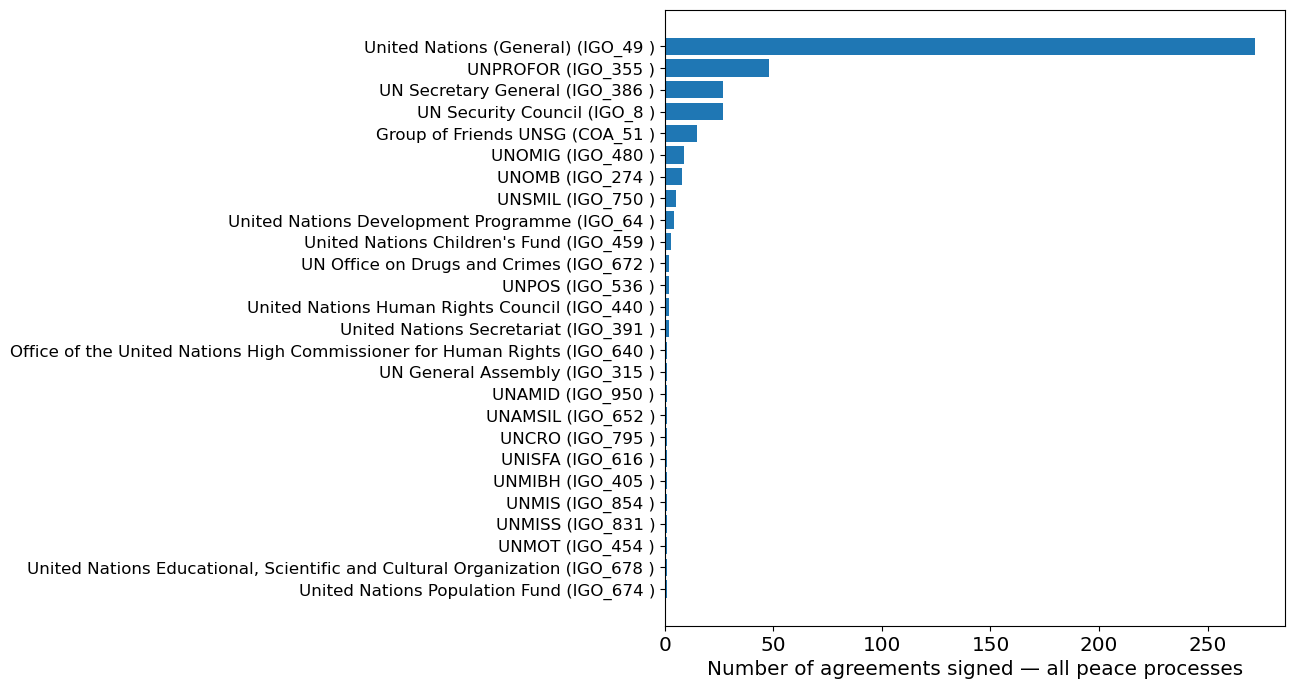

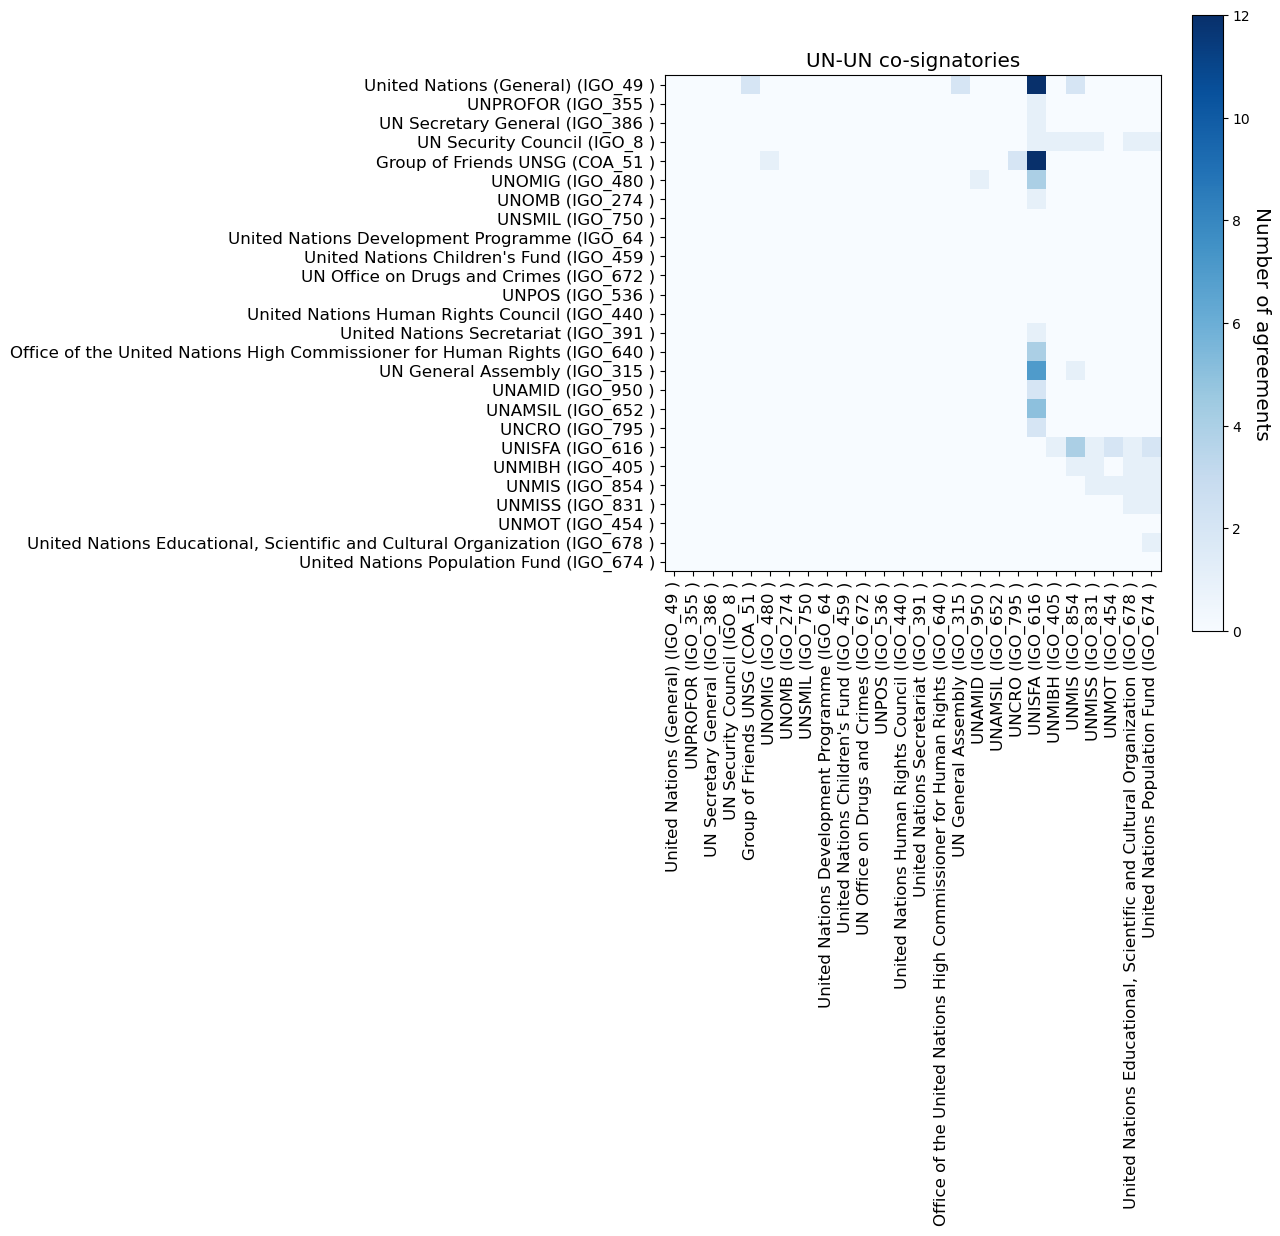

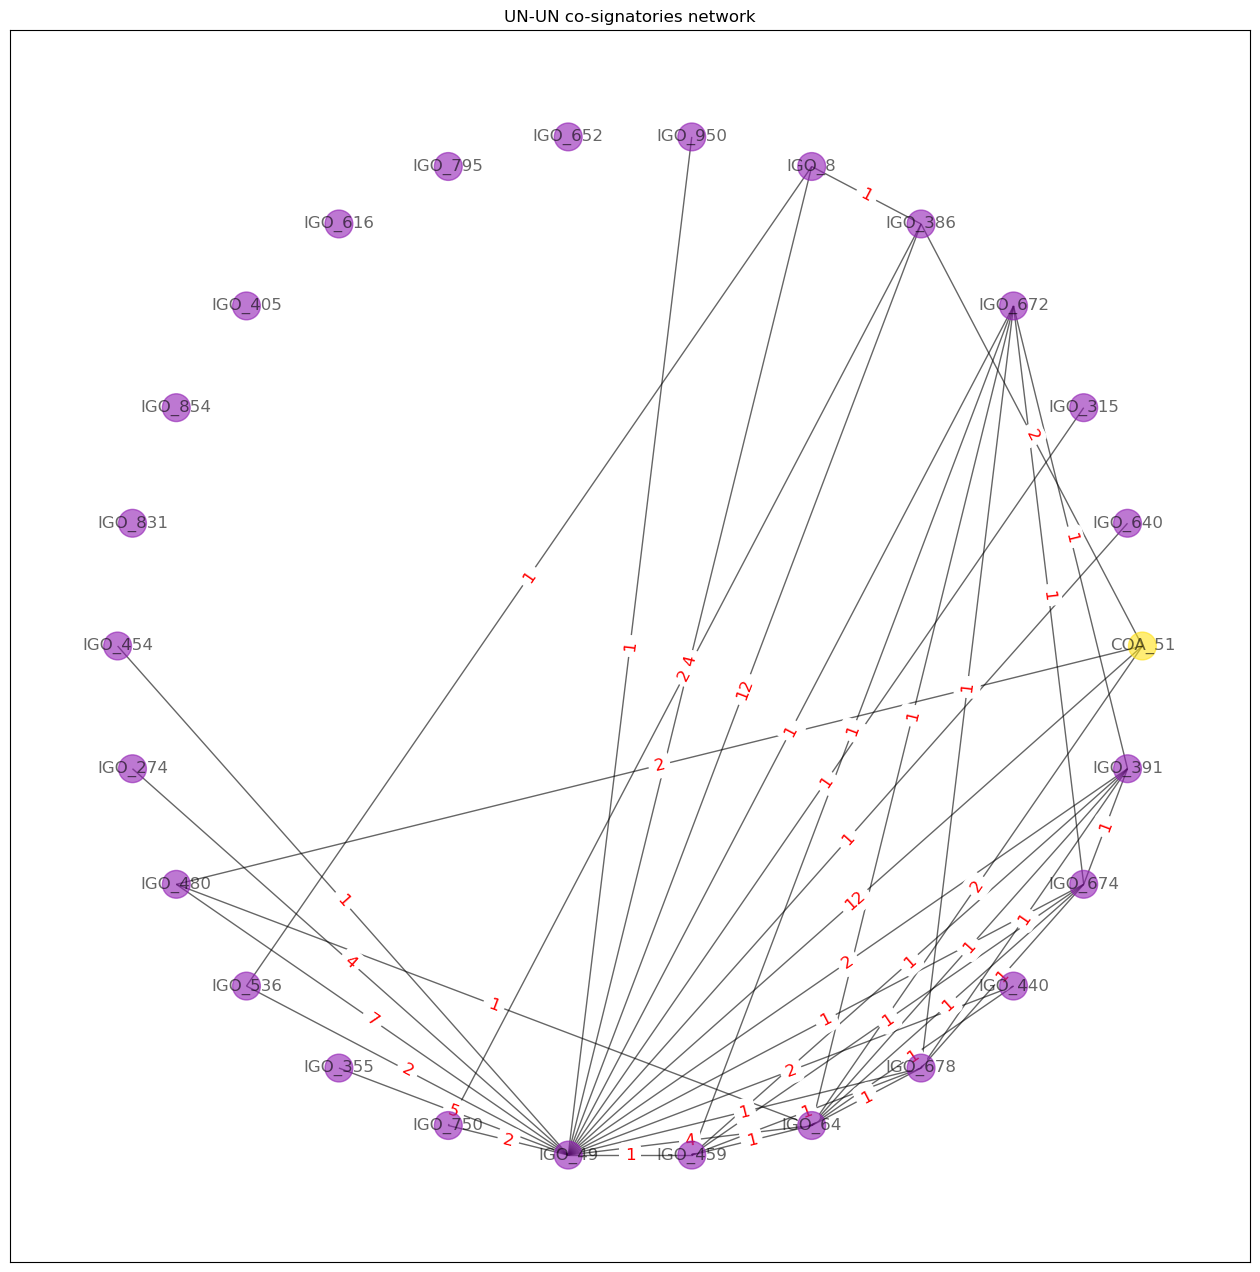

UNAMSIL (IGO\_652) \\
\hline
UNCRO (IGO\_795) \\
\hline
UNISFA (IGO\_616) \\
\hline
UNMIBH (IGO\_405) \\
\hline
UNMIS (IGO\_854) \\
\hline
UNMISS (IGO\_831) \\
\hline


In [7]:
# Get UN actor labels

co_matrices = get_cooccurrence_matrices(un_matrix)
# Upper triangle of actor co-occurence matrix
actor_upper = np.triu(co_matrices[0],k=1)


# Co-occurrence diagonal is the columns marginal of the UN-only biadjacency matrix

diag = np.diag(co_matrices[0])
a = list(zip(diag,un_actors_list))
a = sorted(a,key=lambda t:t[0],reverse=True)
diag = [t[0] for t in a]
label_list = [t[1][2] + ' (' + t[1][1] + ' )' for t in a]

# Number of agreements signed
latex = False
if latex:
    for t in a:
        s = t[1][2] + ' & ' + str(t[0]) + ' \\\\'
        print(s)
        print('\\hline')

f = plt.figure(figsize=(8,8))
plt.barh(range(0,len(diag)),diag)
plt.yticks(range(0,len(label_list)),label_list,fontsize='large')
plt.xticks(fontsize='x-large')
plt.xlabel('Number of agreements signed — all peace processes',fontsize='x-large')
plt.gca().invert_yaxis()
plt.show()

# Heat map
f = plt.figure(figsize=(8,8))
plt.imshow(actor_upper,cmap=plt.cm.Blues)
plt.xticks(range(0,len(label_list)),label_list,rotation=90,fontsize='large')
plt.yticks(range(0,len(label_list)),label_list,fontsize='large')
cbar = plt.colorbar()
cbar.set_label('Number of agreements',rotation=270,labelpad=15,fontsize='x-large')
plt.title('UN-UN co-signatories',fontsize='x-large')
plt.show()

# Network diagram
display_comatrix_as_networkx_graph(co_matrices[0],un_indices,data_dict['actor_vertices'],data_dict,\
                                   title='UN-UN co-signatories network')

rc = np.nonzero(actor_upper) # Row and column indices of non-zero pairs
z = list(zip(list(rc[0]),list(rc[1])))
scores = [(un_actors_list[t[0]][1],un_actors_list[t[0]][2],\
           un_actors_list[t[1]][1],un_actors_list[t[1]][2],actor_upper[t[0]][t[1]]) for t in z]
scores = sorted(scores,key=lambda t:t[4],reverse=True)

# Output for LaTex document
latex = False
if latex:
    for t in scores:
        s = t[1] + ' (' + '\\_'.join(t[0].split('_')) + ') & ' +\
            t[3] + ' (' + '\\_'.join(t[2].split('_')) + ') & ' + str(t[4]) + ' \\\\'
        print(s)
        print('\\hline')

# Locate the singletons
singleton_indices = [index for index,row in enumerate(actor_upper) if np.all(row == 0) and\
                        np.all(actor_upper[:,index] == 0)]
latex = True
if latex:
    for index in singleton_indices:
        singleton_data = un_actors_list[index]
        s = singleton_data[2] + ' (' + '\\_'.join(singleton_data[1].split('_')) + ')' + ' \\\\'
        print(s)
        print('\\hline')



### Analysis: UN and non-UN co-signatories

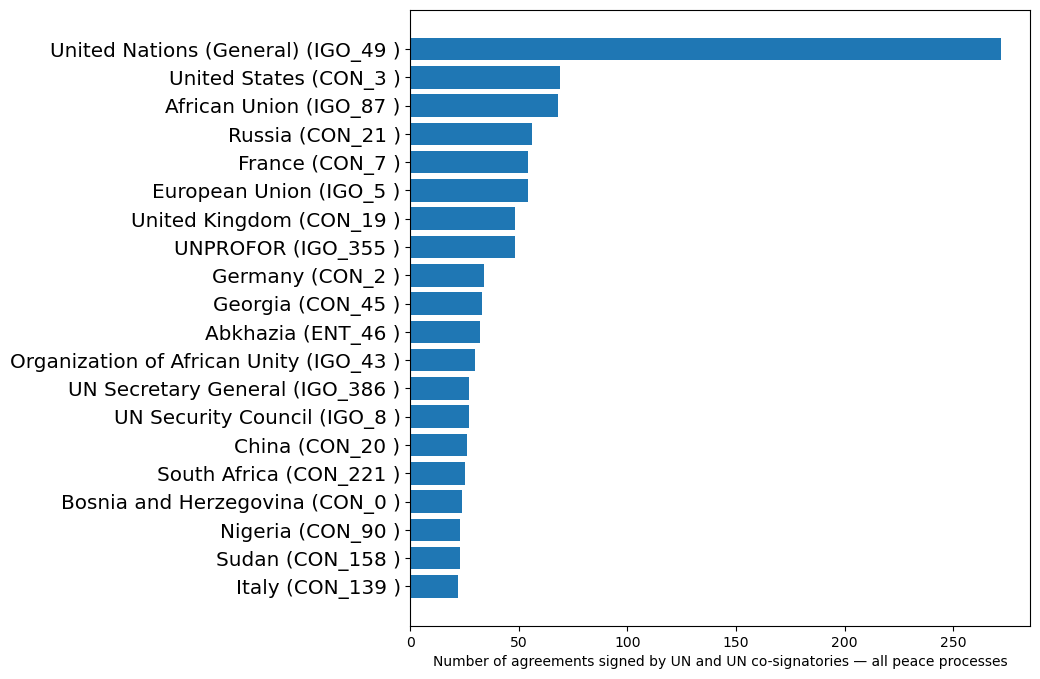

1287
United Nations Secretariat (IGO\_391) & World Food Program (IGO\_673) & 1 \\
\hline
United Nations Secretariat (IGO\_391) & UN Office on Drugs and Crimes (IGO\_672) & 1 \\
\hline
Office of the United Nations High Commissioner for Human Rights (IGO\_640) & North Macedonia (CON\_610) & 1 \\
\hline
Office of the United Nations High Commissioner for Human Rights (IGO\_640) & Luxembourg (CON\_611) & 1 \\
\hline
UN Office on Drugs and Crimes (IGO\_672) & Luxembourg (CON\_611) & 1 \\
\hline
Office of the United Nations High Commissioner for Human Rights (IGO\_640) & Finland (CON\_171) & 1 \\
\hline
Office of the United Nations High Commissioner for Human Rights (IGO\_640) & Bulgaria (CON\_589) & 1 \\
\hline
Office of the United Nations High Commissioner for Human Rights (IGO\_640) & Slovenia (CON\_14) & 1 \\
\hline
Office of the United Nations High Commissioner for Human Rights (IGO\_640) & Sweden (CON\_593) & 1 \\
\hline
Office of the United Nations High Commissioner for Human Rights (I

In [18]:
co_matrices = get_cooccurrence_matrices(un_cosign_matrix)
actor_upper = np.triu(co_matrices[0],k=1)


un_cosign_actor_list = []
for actor_index in actor_indices:
    actor_id = data_dict['actor_vertices'][actor_index]
    actor_data = data_dict['vertices_dict'][actor_id]
    actor_name = actor_data[data_dict['nodes_header'].index('node_name')]
    un_cosign_actor_list.append((actor_index,actor_id,actor_name))

diag = np.diag(co_matrices[0])
a = list(zip(diag,un_cosign_actor_list))
a = sorted(a,key=lambda t:t[0],reverse=True)
diag = [t[0] for t in a]
label_list = [t[1][2] + ' (' + t[1][1] + ' )' for t in a[0:20]]

f = plt.figure(figsize=(8,8))
plt.barh(range(0,len(diag[0:20])),diag[0:20])
plt.yticks(range(0,len(label_list)),label_list,fontsize='x-large')
plt.xlabel('Number of agreements signed by UN and UN co-signatories — all peace processes')
plt.gca().invert_yaxis()
plt.show()

rc = np.nonzero(actor_upper) # Row and column indices of non-zero pairs
z = list(zip(list(rc[0]),list(rc[1])))
scores = [(un_cosign_actor_list[t[0]],un_cosign_actor_list[t[1]],actor_upper[t[0]][t[1]]) for t in z if\
             un_cosign_actor_list[t[0]][0] in un_indices or un_cosign_actor_list[t[1]][0] in un_indices]
scores = sorted(scores,key=lambda t:t[2],reverse=True)


print(len(scores))
latex = False
if latex:
    for t in scores[0:30]:
        a = []
        # Put UN first
        if t[0][0] in un_indices:
            a = (t[0],t[1],t[2])
        else:
            a = (t[1],t[0],t[2])
        s = a[0][2] + ' (' + '\\_'.join(a[0][1].split('_')) + ') & ' +\
        a[1][2] + ' (' + '\\_'.join(a[1][1].split('_')) + ') & ' + str(a[2]) + ' \\\\'
        print(s)
        print('\\hline')

latex = True
if latex:
    for t in scores[-15:]:
        a = []
        # Put UN first
        if t[0][0] in un_indices:
            a = (t[0],t[1],t[2])
        else:
            a = (t[1],t[0],t[2])
        s = a[0][2] + ' (' + '\\_'.join(a[0][1].split('_')) + ') & ' +\
        a[1][2] + ' (' + '\\_'.join(a[1][1].split('_')) + ') & ' + str(a[2]) + ' \\\\'
        print(s)
        print('\\hline')

